<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-05-14 14:59:40--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100% 1.22M=0.02s

2021-05-14 14:59:48 (1.22 MB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



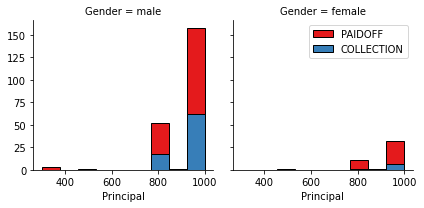

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

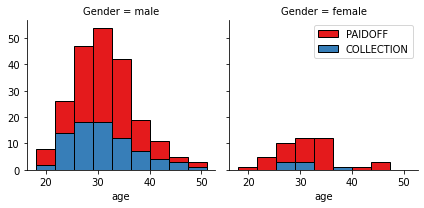

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


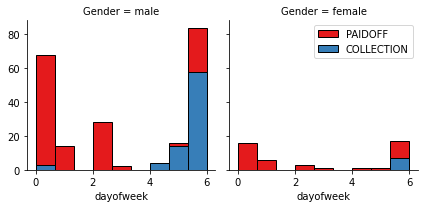

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Splitting the Data into Train Set & Test Set

In [20]:
# Split the X into Train Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [21]:
print ('Train Set:', X_train.shape,  y_train.shape)
print ('Test Set:', X_test.shape,  y_test.shape)

Train Set: (276, 8) (276,)
Test Set: (70, 8) (70,)


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K Nearest Neighbor (KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.

In [22]:
# Importing Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

## First of all, we will try to find the Best Value of 'k'. For this, we will use the following 3 processes,
- GridSearchCV
- RadomisedSearchCV and
- 'for' Loop

## Option 1) Searching for the Best Value of k Using GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and be very costly
- In this approach, since every combination of the hyperparameter values is tried, the process takes a lot of time and is, hence, very inefficient
- Therefore, this search is to be used only when the number of hyperparameters to be searched are less
- In case the number of hyperparameters are more, it is advised to use RandomizedSearchCV
- We can use the GridSearchCV to search for the best values of different hyperparameters in the KNN Algorithm like 'n_neghbors', 'weights', 'algorithm', 'p', etc.
- But for the current Assignment, we will use the GridSearchCV to only search for the Best Value of k and hide the other hyperparameters

In [23]:
knn_grid = KNeighborsClassifier()

params = {
            'n_neighbors' : range(1, 21)
            #'weights' : ['uniform', 'distance'],
            #'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            #'p' : [1, 2]
         }
    
grid_knn = GridSearchCV(estimator = knn_grid,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1)

# Fitting the Model as per the Hyperparameters Identified by the GridSearchCV
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 21)}, scoring='accuracy',
             verbose=1)

In [24]:
# Extracting Best Parameters as per the Hyperparameters Identified by the GridSearchCV
print(grid_knn.best_params_)

{'n_neighbors': 7}


In [25]:
# Predicting the Model as per the Hyperparameters Identified by the GridSearchCV
knn_yhat_grid = grid_knn.predict(X_test)
knn_yhat_grid[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [26]:
# Printing the Metric Scores as per the Best Value of k Identified by the GridSearchCV
print("Train Set - F1 Score: ", f1_score(y_train, grid_knn.predict(X_train), average = 'weighted'))
print("Test Set - F1 Score: ", f1_score(y_test, knn_yhat_grid, average = 'weighted'))
print("\n")
print("Train Set - Jaccard Score: ", jaccard_score(y_train, grid_knn.predict(X_train), average = 'weighted'))
print("Test Set - Jaccard Score: ", jaccard_score(y_test, knn_yhat_grid, average = 'weighted'))
print("\n")
print("Train Set - Accuracy Score: ", accuracy_score(y_train, grid_knn.predict(X_train)))
print("Test Set - Accuracy Score: ", accuracy_score(y_test, knn_yhat_grid))

Train Set - F1 Score:  0.8000194668761034
Test Set - F1 Score:  0.7766540244416351


Train Set - Jaccard Score:  0.6837994124741442
Test Set - Jaccard Score:  0.6627869897959183


Train Set - Accuracy Score:  0.8079710144927537
Test Set - Accuracy Score:  0.7857142857142857


## Option 2) Searching for the Best Value of k Using RandomisedSearchCV
- This search is to be used when the number of hyperparameters to be searched are more
- While it’s possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, but it surprisingly picks the best result more often than not and in a fraction of the time it takes for GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and hence, turn out to be very costly
- In such a case (when there are a lot of hyperparameters to be searched), it is advised to use Randomized Search
- Similar to the GridSearchCV, We can use this option to search for the best values of different hyperparameters in the KNN Algorithm like 'n_neghbors', 'weights', 'algorithm', 'p', etc.
- Note: For this option, 'random_state' is to be used so that the results remain constant and does not change every time this Search option is run
- Again, for the current Assignment, we will use the RandomisedSearchCV to only search for the Best Value of k and hide the other hyperparameters

In [27]:
knn_rcv = KNeighborsClassifier()

params = {
            'n_neighbors' : range(1, 21)
            #'weights' : ['uniform', 'distance'],
            #'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            #'p' : [1, 2]
         }

random_knn = RandomizedSearchCV(estimator = knn_rcv,
                        param_distributions = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1,
                        random_state = 0)

# Fitting the Model as per the Hyperparameters Identified by the RandomisedSearchCV
random_knn.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': range(1, 21)},
                   random_state=0, scoring='accuracy', verbose=1)

In [28]:
# Extracting Best Parameters as per the Hyperparameters Identified by the RandomisedSearchCV
print(random_knn.best_params_)

{'n_neighbors': 7}


In [29]:
# Predicting the Model as per the Hyperparameters Identified by the RandomisedSearchCV
knn_yhat_rcv = random_knn.predict(X_test)
knn_yhat_rcv[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [30]:
# Printing the Metric Scores as per the Best Value of k Identified by the RandomisedSearchCV
print("Train Set - F1 Score: ", f1_score(y_train, random_knn.predict(X_train), average = 'weighted'))
print("Test Set - F1 Score: ", f1_score(y_test, knn_yhat_rcv, average = 'weighted'))
print("\n")
print("Train Set - Jaccard Score: ", jaccard_score(y_train, random_knn.predict(X_train), average = 'weighted'))
print("Test Set - Jaccard Score: ", jaccard_score(y_test, knn_yhat_rcv, average = 'weighted'))
print("\n")
print("Train Set - Accuracy Score: ", accuracy_score(y_train, random_knn.predict(X_train)))
print("Test Set - Accuracy Score: ", accuracy_score(y_test, knn_yhat_rcv))

Train Set - F1 Score:  0.8000194668761034
Test Set - F1 Score:  0.7766540244416351


Train Set - Jaccard Score:  0.6837994124741442
Test Set - Jaccard Score:  0.6627869897959183


Train Set - Accuracy Score:  0.8079710144927537
Test Set - Accuracy Score:  0.7857142857142857


## Option 3) Searching for the Best Value of k Using 'for' Loop
- When the number of hyperparameters are very less, say, a small range of numbers, then we can also use a simple 'for' loop

In [31]:
# Initialising the Variables
ks = range(1, 21) # To find the best value of k
f1_score_knn = []
jaccard_score_knn = []
accuracy_score_knn = []

for n in ks:
    # Training the Model
    knn = KNeighborsClassifier(n_neighbors = n)
    
    # Fitting the Model to the Training Set
    knn.fit(X_train, y_train)
    
    # Predicting the yhat for the Test Set
    knn_yhat = knn.predict(X_test)
    
    # Finding the Accuracy for Different Values of k
    f1_score_knn.append(f1_score(y_test, knn_yhat, average = 'weighted'))
    jaccard_score_knn.append(jaccard_score(y_test, knn_yhat, average = 'weighted'))
    accuracy_score_knn.append(accuracy_score(y_test, knn_yhat))

In [32]:
# Extracting the Best k as Identified by 'for' Loop
print("'n_neighbors': {} ".format(accuracy_score_knn.index(max(accuracy_score_knn)) + 1))

'n_neighbors': 7 


In [33]:
# Training the Model as per the Best k Identified by 'for' Loop
knn = KNeighborsClassifier(n_neighbors = accuracy_score_knn.index(max(accuracy_score_knn)) + 1)

In [34]:
# Fitting the Model as per the Best k Identified by 'for' Loop
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [35]:
# Predicting the Model as per the Best k Identified by 'for' Loop
knn_yhat = knn.predict(X_test)
knn_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [36]:
# Printing the Metric Scores as per the Best Value of k Identified by 'for' Loop
print("Train Set - F1 Score: ", f1_score(y_train, knn.predict(X_train), average = 'weighted'))
print("Test Set - F1 Score: ", f1_score(y_test, knn_yhat, average = 'weighted'))
print("\n")
print("Train Set - Jaccard Score: ", jaccard_score(y_train, knn.predict(X_train), average = 'weighted'))
print("Test Set - Jaccard Score: ", jaccard_score(y_test, knn_yhat, average = 'weighted'))
print("\n")
print("Train Set - Accuracy Score: ", accuracy_score(y_train, knn.predict(X_train)))
print("Test Set - Accuracy Score: ", accuracy_score(y_test, knn_yhat))

Train Set - F1 Score:  0.8000194668761034
Test Set - F1 Score:  0.7766540244416351


Train Set - Jaccard Score:  0.6837994124741442
Test Set - Jaccard Score:  0.6627869897959183


Train Set - Accuracy Score:  0.8079710144927537
Test Set - Accuracy Score:  0.7857142857142857


In [37]:
print("\nAccording to the 3 Search Options above, the K Nearest Neighbour Classifier should have the value of k ('n_neighbors') as: \nk = {} as per GridSearchCV, \nk = {} as per RandomisedSearchCV and \nk = {} as per the 'for' Loop.".format(grid_knn.best_params_['n_neighbors'], random_knn.best_params_['n_neighbors'], accuracy_score_knn.index(max(accuracy_score_knn)) + 1))


According to the 3 Search Options above, the K Nearest Neighbour Classifier should have the value of k ('n_neighbors') as: 
k = 7 as per GridSearchCV, 
k = 7 as per RandomisedSearchCV and 
k = 7 as per the 'for' Loop.


## As can be seen from above, all the search options identified the best value of 'k' as 7
=======================================================================================================================

## Visualising the Data

### Plotting the Values of k V/s F1 Score

Text(0, 0.5, 'F1 Score')

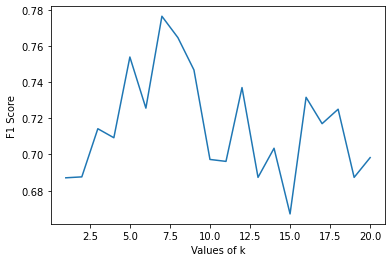

In [38]:
plt.plot(ks, f1_score_knn)
plt.xlabel('Values of k')
plt.ylabel('F1 Score')

### Plotting the Values of k V/s Jaccard Score

Text(0, 0.5, 'Jaccard Score')

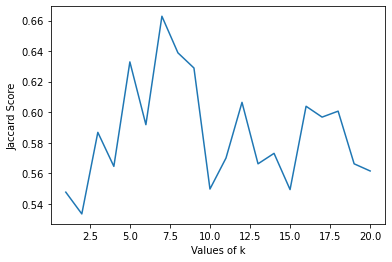

In [39]:
plt.plot(ks, jaccard_score_knn)
plt.xlabel('Values of k')
plt.ylabel('Jaccard Score')

### Plotting the Values of k V/s Accuracy Score

Text(0, 0.5, 'Accuracy Score')

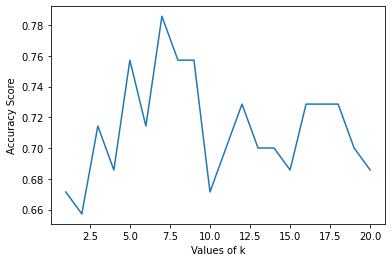

In [40]:
plt.plot(ks, accuracy_score_knn)
plt.xlabel('Values of k')
plt.ylabel('Accuracy Score')

## Training the Model with the Best Value of k

In [41]:
# Importing Libraries
from sklearn.neighbors import KNeighborsClassifier

# KNN Model with the Best Value of k
knn = KNeighborsClassifier(n_neighbors = (f1_score_knn.index(max(f1_score_knn)) + 1))
knn.fit(X_train, y_train)

knn

KNeighborsClassifier(n_neighbors=7)

## Predicting the y_hat

In [42]:
knn_yhat = knn.predict(X_test)
knn_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Plotting the Confusion Matrix

In [43]:
# Importing Libraries
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

Confusion Matrix, without Normalization
[[ 6  9]
 [ 6 49]]


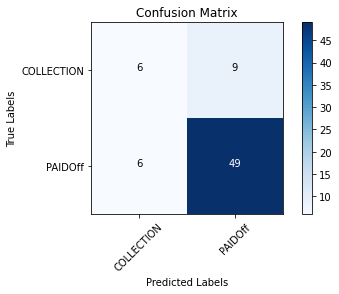

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, knn_yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, knn_yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

## Accuracy Evaluation for K Nearest Neighbor

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

### Creating a df of Metric Scores (F1, Jaccard & Accuracy Scores) for the Best Value of k from the 3 Search Options

In [46]:
# Metric Scores as per the Best Value of k Identified by the GridSearchCV
f1_train_knn_grid = f1_score(y_train, grid_knn.predict(X_train), average = 'weighted')
f1_test_knn_grid = f1_score(y_test, knn_yhat_grid, average = 'weighted')

jaccard_train_knn_grid = jaccard_score(y_train, grid_knn.predict(X_train), average = 'weighted')
jaccard_test_knn_grid = jaccard_score(y_test, knn_yhat_grid, average = 'weighted')

accuracy_train_knn_grid = accuracy_score(y_train, grid_knn.predict(X_train))
accuracy_test_knn_grid = accuracy_score(y_test, knn_yhat_grid)

In [47]:
# Metric Scores as per the Best Value of k Identified by the RandomisedSearchCV
f1_train_knn_rcv = f1_score(y_train, random_knn.predict(X_train), average = 'weighted')
f1_test_knn_rcv = f1_score(y_test, knn_yhat_rcv, average = 'weighted')

jaccard_train_knn_rcv = jaccard_score(y_train, random_knn.predict(X_train), average = 'weighted')
jaccard_test_knn_rcv = jaccard_score(y_test, knn_yhat_rcv, average = 'weighted')

accuracy_train_knn_rcv = accuracy_score(y_train, random_knn.predict(X_train))
accuracy_test_knn_rcv = accuracy_score(y_test, knn_yhat_rcv)

In [48]:
# Metric Scores as per the Best Value of k Identified by 'for' Loop
f1_train_knn_for = f1_score(y_train, knn.predict(X_train), average = 'weighted')
f1_test_knn_for = f1_score(y_test, knn_yhat, average = 'weighted')

jaccard_train_knn_for = jaccard_score(y_train, knn.predict(X_train), average = 'weighted')
jaccard_test_knn_for = jaccard_score(y_test, knn_yhat, average = 'weighted')

accuracy_train_knn_for = accuracy_score(y_train, knn.predict(X_train))
accuracy_test_knn_for = accuracy_score(y_test, knn_yhat)

In [49]:
knn_scores = {'GridSearchCV - Train' : [f1_train_knn_grid, jaccard_train_knn_grid, accuracy_train_knn_grid],
              'GridSearchCV - Test' : [f1_test_knn_grid, jaccard_test_knn_grid, accuracy_test_knn_grid],
              'RamdomisedSearchCV - Train' : [f1_train_knn_rcv, jaccard_train_knn_rcv, accuracy_train_knn_rcv],
              'RamdomisedSearchCV - Test' : [f1_test_knn_rcv, jaccard_test_knn_rcv, accuracy_test_knn_rcv],
              'For Loop - Train' : [f1_train_knn_for, jaccard_train_knn_for, accuracy_train_knn_for],
              'For Loop - Test' : [f1_test_knn_for, jaccard_test_knn_for, accuracy_test_knn_for]
             }

index = ['F1 Score', 'Jaccard Score', 'Accuracy Score']

col = ['GridSearchCV - Train', 'GridSearchCV - Test', 'RamdomisedSearchCV - Train', 'RamdomisedSearchCV - Test', 'For Loop - Train', 'For Loop - Test']

knn_hyperparameters_df = pd.DataFrame(knn_scores, index = index, columns = col)

knn_hyperparameters_df.columns.name = 'KNN Scores'

knn_hyperparameters_df

KNN Scores,GridSearchCV - Train,GridSearchCV - Test,RamdomisedSearchCV - Train,RamdomisedSearchCV - Test,For Loop - Train,For Loop - Test
F1 Score,0.800019,0.776654,0.800019,0.776654,0.800019,0.776654
Jaccard Score,0.683799,0.662787,0.683799,0.662787,0.683799,0.662787
Accuracy Score,0.807971,0.785714,0.807971,0.785714,0.807971,0.785714


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Decision Tree

In [50]:
# Importing Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

## Searching for the Best Value of max_depth Using 'for' Loop
- When the number of hyperparameters are very less, say, a small range of numbers, then we can also use a simple 'for' loop

In [51]:
# Initialising Variables
depth_range = range(1, 21) # To find the best value of max_depth
f1_score_dt = []
jaccard_score_dt = []

for d in depth_range:
    # Training the Model
    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = d)
    
    # Fitting the Model to the Training Set
    dt.fit(X_train, y_train)
    
    # Predicting the yhat for the Test Set
    dt_yhat = dt.predict(X_test)
    
    # Finding the Accuracy for Different Values of max_depth
    f1_score_dt.append(f1_score(y_test, dt_yhat, average = 'weighted'))
    jaccard_score_dt.append(jaccard_score(y_test, dt_yhat, average = 'weighted'))

### Best Value of max_depth

In [52]:
# Best Value of max_depth using F1 Score
for d, f in zip(depth_range, f1_score_dt):
    print("max_depth = {} has an F1 Score of {} ".format(d, f))

print("\nmax_depth = {} has the Highest F1 Score of {} ".format(f1_score_dt.index(max(f1_score_dt)) + 1, max(f1_score_dt)))
print("\nHence, as per the F1 Score, the Decision Tree Classifier should have the value of max_depth = {} ".format(f1_score_dt.index(max(f1_score_dt)) + 1))

max_depth = 1 has an F1 Score of 0.6914285714285714 
max_depth = 2 has an F1 Score of 0.6914285714285714 
max_depth = 3 has an F1 Score of 0.6445993031358885 
max_depth = 4 has an F1 Score of 0.6445993031358885 
max_depth = 5 has an F1 Score of 0.6588921282798834 
max_depth = 6 has an F1 Score of 0.7238095238095238 
max_depth = 7 has an F1 Score of 0.7142857142857142 
max_depth = 8 has an F1 Score of 0.7073291925465839 
max_depth = 9 has an F1 Score of 0.6709252806813782 
max_depth = 10 has an F1 Score of 0.697320223636013 
max_depth = 11 has an F1 Score of 0.709430756159728 
max_depth = 12 has an F1 Score of 0.7205687830687831 
max_depth = 13 has an F1 Score of 0.7371040174778494 
max_depth = 14 has an F1 Score of 0.7450238032762304 
max_depth = 15 has an F1 Score of 0.7598407784166297 
max_depth = 16 has an F1 Score of 0.7181842036210967 
max_depth = 17 has an F1 Score of 0.7181842036210967 
max_depth = 18 has an F1 Score of 0.7181842036210967 
max_depth = 19 has an F1 Score of 0.718

In [53]:
# Best Value of max_depth using Jaccard Score
for d, j in zip(depth_range, jaccard_score_dt):
    print("max_depth = {} has an Jaccard Score of {} ".format(d, f))

print("\nmax_depth = {} has the Highest Jaccard Score of {} ".format(jaccard_score_dt.index(max(jaccard_score_dt)) + 1, max(jaccard_score_dt)))
print("\nHence, as per the Jaccard Score, the Decision Tree Classifier should have the value of max_depth = {} ".format(jaccard_score_dt.index(max(jaccard_score_dt)) + 1))

max_depth = 1 has an Jaccard Score of 0.7181842036210967 
max_depth = 2 has an Jaccard Score of 0.7181842036210967 
max_depth = 3 has an Jaccard Score of 0.7181842036210967 
max_depth = 4 has an Jaccard Score of 0.7181842036210967 
max_depth = 5 has an Jaccard Score of 0.7181842036210967 
max_depth = 6 has an Jaccard Score of 0.7181842036210967 
max_depth = 7 has an Jaccard Score of 0.7181842036210967 
max_depth = 8 has an Jaccard Score of 0.7181842036210967 
max_depth = 9 has an Jaccard Score of 0.7181842036210967 
max_depth = 10 has an Jaccard Score of 0.7181842036210967 
max_depth = 11 has an Jaccard Score of 0.7181842036210967 
max_depth = 12 has an Jaccard Score of 0.7181842036210967 
max_depth = 13 has an Jaccard Score of 0.7181842036210967 
max_depth = 14 has an Jaccard Score of 0.7181842036210967 
max_depth = 15 has an Jaccard Score of 0.7181842036210967 
max_depth = 16 has an Jaccard Score of 0.7181842036210967 
max_depth = 17 has an Jaccard Score of 0.7181842036210967 
max_de

### Creating a df to check the best value of max_depth

In [54]:
result_dt = pd.DataFrame([f1_score_dt, jaccard_score_dt], index = ['F1 Score', 'Jaccard Score'], columns = ['d = 1','d = 2','d = 3','d = 4','d = 5','d = 6','d = 7','d = 8','d = 9', 'd = 10', 'd = 11', 'd = 12', 'd = 13', 'd = 14', 'd = 15', 'd = 16', 'd = 17', 'd = 18', 'd = 19', 'd = 20'])
result_dt.columns.name = 'Max. Depth'
result_dt

Max. Depth,d = 1,d = 2,d = 3,d = 4,d = 5,d = 6,d = 7,d = 8,d = 9,d = 10,d = 11,d = 12,d = 13,d = 14,d = 15,d = 16,d = 17,d = 18,d = 19,d = 20
F1 Score,0.691429,0.691429,0.644599,0.644599,0.658892,0.72381,0.714286,0.707329,0.670925,0.697320,0.709431,0.720569,0.737104,0.745024,0.759841,0.718184,0.718184,0.718184,0.718184,0.718184
Jaccard Score,0.617347,0.617347,0.493097,0.493097,0.506641,0.62465,0.611842,0.592121,0.520842,0.579123,0.575521,0.589629,0.606445,0.609861,0.626531,0.578699,0.578699,0.578699,0.578699,0.578699


In [55]:
print("\nAccording to the above, the Decision Tree Classifier should have the value of max_depth as: \nmax_depth = {} as per F1 Score and \nmax_depth = {} as per Jaccard Score.".format(f1_score_dt.index(max(f1_score_dt)) + 1, jaccard_score_dt.index(max(jaccard_score_dt)) + 1))


According to the above, the Decision Tree Classifier should have the value of max_depth as: 
max_depth = 15 as per F1 Score and 
max_depth = 15 as per Jaccard Score.


## Visualising the Data

### Plotting the Values of max_depth V/s F1 Score

Text(0, 0.5, 'F1 Score')

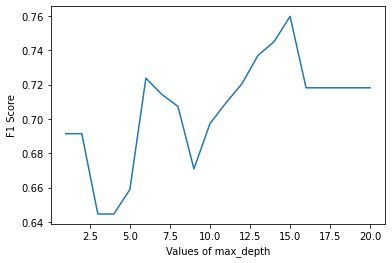

In [56]:
plt.plot(depth_range, f1_score_dt)
plt.xlabel('Values of max_depth')
plt.ylabel('F1 Score')

### Plotting the Values of max_depth V/s Jaccard Score

Text(0, 0.5, 'Jaccard Score')

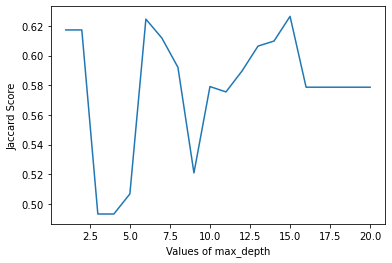

In [57]:
plt.plot(depth_range, jaccard_score_dt)
plt.xlabel('Values of max_depth')
plt.ylabel('Jaccard Score')

In [58]:
print("Max. Depth as per the Highest F1 Score: ", f1_score_dt.index(max(f1_score_dt)) + 1)
print("Max. Depth as per the Highest Jaccard Score: ", jaccard_score_dt.index(max(jaccard_score_dt)) + 1)

Max. Depth as per the Highest F1 Score:  15
Max. Depth as per the Highest Jaccard Score:  15


## Training the Model with the Best Value of max_depth

In [59]:
# Importing Libraries
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Model with the Best Value of max_depth
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = (f1_score_dt.index(max(f1_score_dt)) + 1))

# Fitting the Model to the Training Set
dt.fit(X_train, y_train)
                     
dt

DecisionTreeClassifier(max_depth=15)

## Predicting the y_hat

In [60]:
dt_yhat = dt.predict(X_test)
dt_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Plotting the Confusion Matrix

In [61]:
# Importing Libraries
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

              precision    recall  f1-score   support

  COLLECTION       0.43      0.67      0.53        15
     PAIDOFF       0.89      0.76      0.82        55

    accuracy                           0.74        70
   macro avg       0.66      0.72      0.67        70
weighted avg       0.80      0.74      0.76        70

Confusion Matrix, without Normalization
[[10  5]
 [13 42]]


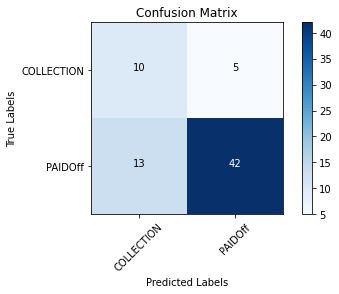

In [63]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, dt_yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, dt_yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

## Accuracy Evaluation for Decision Tree

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [64]:
# Metric Scores as per the Best Value of max_depth Identified by 'for' Loop
f1_train_dt_for = f1_score(y_train, dt.predict(X_train), average = 'weighted')
f1_test_dt_for = f1_score(y_test, dt_yhat, average = 'weighted')

jaccard_train_dt_for = jaccard_score(y_train, dt.predict(X_train), average = 'weighted')
jaccard_test_dt_for = jaccard_score(y_test, dt_yhat, average = 'weighted')

accuracy_train_dt_for = accuracy_score(y_train, dt.predict(X_train))
accuracy_test_dt_for = accuracy_score(y_test, dt_yhat)

In [65]:
dt_scores = {'Train' : [f1_train_dt_for, jaccard_train_dt_for, accuracy_train_dt_for],
              'Test' : [f1_test_dt_for, jaccard_test_dt_for, accuracy_test_dt_for]
             }

index = ['F1 Score', 'Jaccard Score', 'Accuracy Score']

col = ['Train', 'Test']

dt_hyperparameters_df = pd.DataFrame(dt_scores, index = index, columns = col)

dt_hyperparameters_df.columns.name = 'Decision Tree Scores'

dt_hyperparameters_df

Decision Tree Scores,Train,Test
F1 Score,0.899007,0.759841
Jaccard Score,0.820846,0.626531
Accuracy Score,0.898551,0.742857


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Support Vector Machine


In [66]:
# Importing Libraries
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
%matplotlib inline

## Option 1) Searching for the Best Hyperparameters Using GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and be very costly
- In this approach, since every combination of the hyperparameter values is tried, the process takes a lot of time and is, hence, very inefficient
- Therefore, this search is to be used only when the number of hyperparameters to be searched are less
- In case the number of hyperparameters are more, it is advised to use RandomizedSearchCV
- We can use the GridSearchCV to search for the best values of different hyperparameters in the SVM Algorithm like 'C', 'kernel', 'degree', etc.

In [67]:
svc = SVC()

params = {
            'C' : np.arange(0, 1, 0.1),
            'kernel' : ['sigmoid', 'linear', 'poly', 'rbf'],
            'degree' : range(1, 21)
        }

grid_svc = GridSearchCV(estimator = svc,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1)

# Fitting the Model as per the Hyperparameters Identified by the GridSearchCV
grid_svc.fit(X_train, y_train)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 0.74 0.74 0.74 0.74
 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74
 0.75 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.73 0.74
 0.74 0.74 0.73 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74
 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.75 0.74
 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.74
 0.74 0.74 0.74 0.74 0.74 0.74 0.74 0.72 0.74 0.74 0.74 0.72 0.74 0.74
 0.74

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'degree': range(1, 21),
                         'kernel': ['sigmoid', 'linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=1)

In [68]:
# Extracting Best Parameters
print(grid_svc.best_params_)

{'C': 0.1, 'degree': 15, 'kernel': 'poly'}


In [69]:
# Score for the Best Fit
print(grid_svc.score(X_test, y_test))

0.7571428571428571


### Training the Model Using Results from GridSearchCV

In [70]:
# Importing Libraries
from sklearn.svm import SVC

# Support Vector Machine Model with the Best Hyperparameters
svc_model_grid = SVC(kernel = grid_svc.best_params_['kernel'], C = grid_svc.best_params_['C'], degree = grid_svc.best_params_['degree'])

# Fitting the Model to the Training Set
svc_model_grid.fit(X_train, y_train)

svc_model_grid

SVC(C=0.1, degree=15, kernel='poly')

### Predicting the y_hat Using Results from GridSearchCV

In [71]:
svc_yhat_grid = svc_model_grid.predict(X_test)
svc_yhat_grid[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [72]:
print(svc_model_grid.score(X_test, y_test))

0.7571428571428571


### Plotting the Confusion Matrix Using Results from GridSearchCV

              precision    recall  f1-score   support

  COLLECTION       0.25      0.07      0.11        15
     PAIDOFF       0.79      0.95      0.86        55

    accuracy                           0.76        70
   macro avg       0.52      0.51      0.48        70
weighted avg       0.67      0.76      0.70        70

Confusion Matrix, without Normalization
[[ 1 14]
 [ 3 52]]


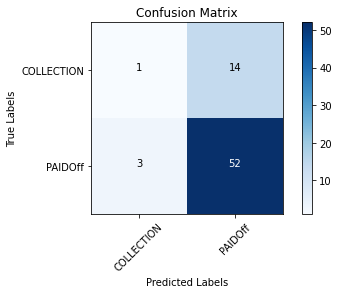

In [73]:
# Compute confusion matrix
cnf_matrix_grid = confusion_matrix(y_test, svc_yhat_grid)
np.set_printoptions(precision=2)

print(classification_report(y_test, svc_yhat_grid))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grid, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using Results from GridSearchCV

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [74]:
# Metric Scores as per the Best Values of Hypermeters Identified by the GridSearchCV
f1_train_svc_grid = f1_score(y_train, svc_model_grid.predict(X_train), average = 'weighted')
f1_test_svc_grid = f1_score(y_test, svc_yhat_grid, average = 'weighted')

jaccard_train_svc_grid = jaccard_score(y_train, svc_model_grid.predict(X_train), average = 'weighted')
jaccard_test_svc_grid = jaccard_score(y_test, svc_yhat_grid, average = 'weighted')

accuracy_train_svc_grid = accuracy_score(y_train, svc_model_grid.predict(X_train))
accuracy_test_svc_grid = accuracy_score(y_test, svc_yhat_grid)

In [75]:
print("Train Set F1 Score Using Results from GridSearchCV: ", f1_train_svc_grid)
print("Test Set F1 Score Using Results from GridSearchCV: ", f1_test_svc_grid)
print("\n")
print("Score Train Set Jaccard Score Using Results from GridSearchCV: ", jaccard_train_svc_grid)
print("Test Set Jaccard Score Using Results from GridSearchCV: ", jaccard_test_svc_grid)
print("\n")
print("Train Set Accuracy Score Using Results from GridSearchCV: ", accuracy_train_svc_grid)
print("Test Set Accuracy Score Using Results from GridSearchCV: ", accuracy_test_svc_grid)

Train Set F1 Score Using Results from GridSearchCV:  0.7466550815501339
Test Set F1 Score Using Results from GridSearchCV:  0.6978810663021189


Score Train Set Jaccard Score Using Results from GridSearchCV:  0.639941781246129
Test Set Jaccard Score Using Results from GridSearchCV:  0.6040372670807455


Train Set Accuracy Score Using Results from GridSearchCV:  0.7971014492753623
Test Set Accuracy Score Using Results from GridSearchCV:  0.7571428571428571


## Option 2) Searching for the Best Hyperparameters Using RandomisedSearchCV
- This search is to be used when the number of hyperparameters to be searched are more
- While it’s possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, but it surprisingly picks the best result more often than not and in a fraction of the time it takes for GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and hence, turn out to be very costly
- In such a case (when there are a lot of hyperparameters to be searched), it is advised to use Randomized Search
- Similar to the GridSearchCV, We can use this option to search for the best values of different hyperparameters in the SVM Algorithm like 'C', 'kernel', 'degree', 'gamma', etc.
- Note: For this option, 'random_state' is to be used so that the results remain constant and does not change every time this Search option is run

In [76]:
svc = SVC()

params = {
            'C' : np.arange(0, 1, 0.001),
            'kernel' : ['sigmoid', 'linear', 'poly', 'rbf'],
            'degree' : range(1, 21),
            'gamma' : ['scale', 'auto']
        }

random_svc = RandomizedSearchCV(estimator = svc,
                        param_distributions = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1,
                        random_state = 5)

# Fitting the Model as per the Hyperparameters Identified by the RandomisedSearchCV
random_svc.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0....
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96, 0.96,
       0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.97, 0.97,
       0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.  , 1.  , 1.  , 1.  ]),
                                        'degree': range(1, 21),
                                        'gamma': ['scale', 'auto'],
                              

In [77]:
# Extracting Best Parameters
print(random_svc.best_params_)

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 1, 'C': 0.223}


In [78]:
# Score for the Best Fit
print(random_svc.score(X_test, y_test))

0.7857142857142857


### Training the Model Using Results from RandomisedSearchCV

In [79]:
# Importing Libraries
from sklearn.svm import SVC
               
# Support Vector Machine Model with the Best Kernel Function as per F1 Score
svc_model_rcv = SVC(kernel = random_svc.best_params_['kernel'], C = random_svc.best_params_['C'], degree = random_svc.best_params_['degree'], gamma = random_svc.best_params_['gamma'])

# Fitting the Model to the Training Set
svc_model_rcv.fit(X_train, y_train)

svc_model_rcv

SVC(C=0.223, degree=1)

 ### Predicting the y_hat Using Results from RandomisedSearchCV

In [80]:
svc_yhat_rcv = svc_model_rcv.predict(X_test)
svc_yhat_rcv[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [81]:
print(svc_model_rcv.score(X_test, y_test))

0.7857142857142857


### Plotting the Confusion Matrix Using Results from RandomisedSearchCV

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion Matrix, without Normalization
[[ 0 15]
 [ 0 55]]


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


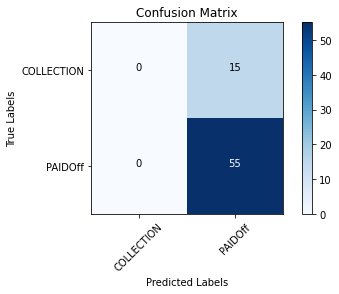

In [82]:
# Compute confusion matrix
cnf_matrix_rcv = confusion_matrix(y_test, svc_yhat_rcv)
np.set_printoptions(precision=2)

print(classification_report(y_test, svc_yhat_rcv))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rcv, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using Results from RandomisedSearchCV

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [83]:
# Metric Scores as per the Best Values of Hypermeters Identified by the RandomisedSearchCV
f1_train_svc_rcv = f1_score(y_train, svc_model_rcv.predict(X_train), average = 'weighted')
f1_test_svc_rcv = f1_score(y_test, svc_yhat_rcv, average = 'weighted')

jaccard_train_svc_rcv = jaccard_score(y_train, svc_model_rcv.predict(X_train), average = 'weighted')
jaccard_test_svc_rcv = jaccard_score(y_test, svc_yhat_rcv, average = 'weighted')

accuracy_train_svc_rcv = accuracy_score(y_train, svc_model_rcv.predict(X_train))
accuracy_test_svc_rcv = accuracy_score(y_test, svc_yhat_rcv)

In [84]:
print("Score Train Set F1 Score Using Results from RandomisedSearchCV: ", f1_train_svc_rcv)
print("Score Test Set F1 Score Using Results from RandomisedSearchCV: ", f1_test_svc_rcv)
print("\n")
print("Score Train Set Jaccard Score Using Results from RandomisedSearchCV: ", jaccard_train_svc_rcv)
print("Score Test Set Jaccard Score Using Results from RandomisedSearchCV: ", jaccard_test_svc_rcv)
print("\n")
print("Train Set Accuracy Score Using Results from RandomisedSearchCV: ", accuracy_train_svc_rcv)
print("Test Set Accuracy Score Using Results from RandomisedSearchCV: ", accuracy_test_svc_rcv)

Score Train Set F1 Score Using Results from RandomisedSearchCV:  0.6331163939859591
Score Test Set F1 Score Using Results from RandomisedSearchCV:  0.6914285714285714


Score Train Set Jaccard Score Using Results from RandomisedSearchCV:  0.5516829447595043
Score Test Set Jaccard Score Using Results from RandomisedSearchCV:  0.6173469387755102


Train Set Accuracy Score Using Results from RandomisedSearchCV:  0.7427536231884058
Test Set Accuracy Score Using Results from RandomisedSearchCV:  0.7857142857142857


## Option 3) Searching for the Best Value of Kernel Function Using 'for' Loop
- When the number of hyperparameters are very less, say, a small list of Kernel Functions, then we can use a 'for' loop

In [85]:
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
f1_score_svc = []
jaccard_score_svc = []

for k in kernel_func:
    # Training the Model
    svc_model = SVC(kernel = k)
    # Fitting the Model to the Training Set
    svc_model.fit(X_train, y_train)

    # Predicting the yhat for the Test Set
    svc_yhat = svc_model.predict(X_test)

    # Finding the Accuracy for Different Kernel Functions
    f1_score_svc.append(f1_score(y_test, svc_yhat, average = 'weighted'))
    jaccard_score_svc.append(jaccard_score(y_test, svc_yhat, average = 'weighted'))

In [86]:
# Best Kernel Function using F1 Score
for k, f in zip(kernel_func, f1_score_svc):
    print("SVM Model with Kernel Function = '{}' has an F1 Score of {} ".format(k, f))

SVM Model with Kernel Function = 'sigmoid' has an F1 Score of 0.6892857142857144 
SVM Model with Kernel Function = 'poly' has an F1 Score of 0.7064793130366899 
SVM Model with Kernel Function = 'rbf' has an F1 Score of 0.7275882012724117 
SVM Model with Kernel Function = 'linear' has an F1 Score of 0.6914285714285714 


In [87]:
# Best Kernel Function using Jaccard Score
for k, j in zip(kernel_func, jaccard_score_svc):
    print("SVM Model with Kernel Function = '{}' has an Jaccard Score of {} ".format(k, j))

SVM Model with Kernel Function = 'sigmoid' has an Jaccard Score of 0.5920235371036286 
SVM Model with Kernel Function = 'poly' has an Jaccard Score of 0.6161247107538668 
SVM Model with Kernel Function = 'rbf' has an Jaccard Score of 0.6103896103896104 
SVM Model with Kernel Function = 'linear' has an Jaccard Score of 0.6173469387755102 


### Creating a df to check the Best Kernel Function Using 'for' Loop

In [88]:
result_svc = pd.DataFrame([f1_score_svc, jaccard_score_svc], index = ['F1 Score', 'Jaccard Score'], columns = ['sigmoid', 'poly', 'rbf', 'linear'])
result_svc.columns.name = 'Kernel Function'
result_svc

Kernel Function,sigmoid,poly,rbf,linear
F1 Score,0.689286,0.706479,0.727588,0.691429
Jaccard Score,0.592024,0.616125,0.610390,0.617347


### Plotting the Kernel Functions V/s F1 Score Using 'for' Loop

Text(0, 0.5, 'F1 Score')

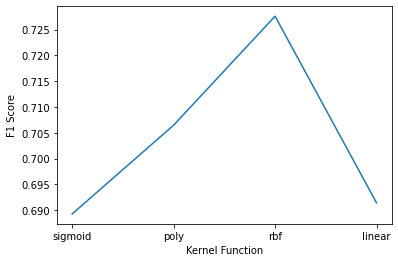

In [89]:
plt.plot(kernel_func, f1_score_svc)
plt.xlabel('Kernel Function')
plt.ylabel('F1 Score')

### Plotting the Kernel Functions V/s Jaccard Score Using 'for' Loop

Text(0, 0.5, 'Jaccard Score')

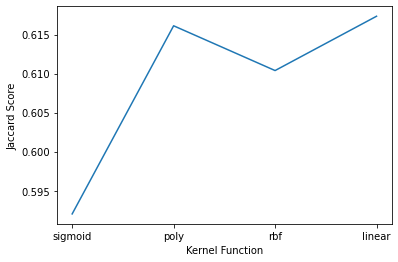

In [90]:
plt.plot(kernel_func, jaccard_score_svc)
plt.xlabel('Kernel Function')
plt.ylabel('Jaccard Score')

### Best Kernel Function as per the Charts Using 'for' Loop
- The best Kernel Function as per F1 Score is 'rbf'
- Also, since the Jaccard Scores for 'poly', 'rbf' & 'linear' are very close to each other, we will use 'rbf' as the Kernel Function for this Support Vector Machine

### Training the Model Using 'for' Loop

In [91]:
# Importing Libraries
from sklearn.svm import SVC

# Initiating Variables
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
               
# Support Vector Machine Model with the Best Kernel Function as per F1 Score
svc_model_for = SVC(kernel = kernel_func[(f1_score_svc.index(max(f1_score_svc)))])

# Fitting the Model to the Training Set
svc_model_for.fit(X_train, y_train)

svc_model_for

SVC()

In [92]:
kernel_func[(f1_score_svc.index(max(f1_score_svc)))]

'rbf'

### Predicting the y_hat Using 'for' Loop

In [93]:
svc_yhat_for = svc_model_for.predict(X_test)
svc_yhat_for[0 : 10]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [94]:
print(svc_model_for.score(X_test, y_test))

0.7428571428571429


### Plotting the Confusion Matrix Using 'for' Loop

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion Matrix, without Normalization
[[ 4 11]
 [ 7 48]]


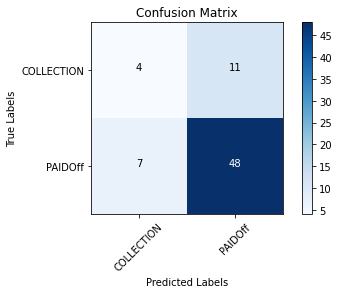

In [95]:
# Compute confusion matrix
cnf_matrix_for = confusion_matrix(y_test, svc_yhat_for)
np.set_printoptions(precision=2)

print(classification_report(y_test, svc_yhat_for))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_for, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using 'for' Loop

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [96]:
# Metric Scores as per the Best Values of Hypermeters Identified by the 'for' Loop
f1_train_svc_for = f1_score(y_train, svc_model_for.predict(X_train), average = 'weighted')
f1_test_svc_for = f1_score(y_test, svc_yhat_for, average = 'weighted')

jaccard_train_svc_for = jaccard_score(y_train, svc_model_for.predict(X_train), average = 'weighted')
jaccard_test_svc_for = jaccard_score(y_test, svc_yhat_for, average = 'weighted')

accuracy_train_svc_for = accuracy_score(y_train, svc_model_for.predict(X_train))
accuracy_test_svc_for = accuracy_score(y_test, svc_yhat_for)

In [97]:
print("Train Set - F1 Score: ", f1_train_svc_for)
print("Test Set - F1 Score: ", f1_test_svc_for)
print("\n")
print("Train Set - Jaccard Score: ", jaccard_train_svc_for)
print("Test Set - Jaccard Score: ", jaccard_test_svc_for)
print("\n")
print("Train Set - Accuracy Score: ", accuracy_train_svc_for)
print("Test Set - Accuracy Score: ", accuracy_test_svc_for)

Train Set - F1 Score:  0.7682165861513688
Test Set - F1 Score:  0.7275882012724117


Train Set - Jaccard Score:  0.6473429951690821
Test Set - Jaccard Score:  0.6103896103896104


Train Set - Accuracy Score:  0.782608695652174
Test Set - Accuracy Score:  0.7428571428571429


## Accuracy Evaluation for Support Vector Machine

### Creating a df to check the Accuracy Evaluation Using the 3 Search Options

In [98]:
svc_scores = {'GridSearchCV - Train' : [f1_train_svc_grid, jaccard_train_svc_grid, accuracy_train_svc_grid],
              'GridSearchCV - Test' : [f1_test_svc_grid, jaccard_test_svc_grid, accuracy_test_svc_grid],
              'RamdomisedSearchCV - Train' : [f1_train_svc_rcv, jaccard_train_svc_rcv, accuracy_train_svc_rcv],
              'RamdomisedSearchCV - Test' : [f1_test_svc_rcv, jaccard_test_svc_rcv, accuracy_test_svc_rcv],
              'For Loop - Train' : [f1_train_svc_for, jaccard_train_svc_for, accuracy_train_svc_for],
              'For Loop - Test' : [f1_test_svc_for, jaccard_test_svc_for, accuracy_test_svc_for]
             }

index = ['F1 Score', 'Jaccard Score', 'Accuracy Score']

col = ['GridSearchCV - Train', 'GridSearchCV - Test', 'RamdomisedSearchCV - Train', 'RamdomisedSearchCV - Test', 'For Loop - Train', 'For Loop - Test']

svc_hyperparameters_df = pd.DataFrame(svc_scores, index = index, columns = col)

svc_hyperparameters_df.columns.name = 'SVC Scores'

svc_hyperparameters_df

SVC Scores,GridSearchCV - Train,GridSearchCV - Test,RamdomisedSearchCV - Train,RamdomisedSearchCV - Test,For Loop - Train,For Loop - Test
F1 Score,0.746655,0.697881,0.633116,0.691429,0.768217,0.727588
Jaccard Score,0.639942,0.604037,0.551683,0.617347,0.647343,0.610390
Accuracy Score,0.797101,0.757143,0.742754,0.785714,0.782609,0.742857


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Logistic Regression


In [99]:
# Importing Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

## Option 1) Searching for the Best Hyperparameters Using GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and be very costly
- In this approach, since every combination of the hyperparameter values is tried, the process takes a lot of time and is, hence, very inefficient
- Therefore, this search is to be used only when the number of hyperparameters to be searched are less
- In case the number of hyperparameters are more, it is advised to use RandomizedSearchCV
- We can use the GridSearchCV to search for the best values of different hyperparameters in the Logistic Regression Algorithm like 'C', 'penalty', 'solver', etc.

In [100]:
lr = LogisticRegression()

params = {
            'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
            'C' : np.arange(0, 1, 0.1),
            'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
        }

grid_lr = GridSearchCV(estimator = lr,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1)

# Fitting the Model as per the Hyperparameters Identified by the GridSearchCV
grid_lr.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ nan  nan  nan  nan 0.74  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan 0.71 0.71 0.71 0.71 0.74  nan  nan  nan 0.74 0.72 0.74 0.74
 0.74 0.74  nan  nan  nan  nan  nan  nan 0.71 0.71 0.71 0.71 0.72  nan
  nan  nan 0.74 0.72 0.73 0.73 0.73 0.73  nan  nan  nan  nan  nan  nan
 0.71 0.71 0.71 0.71 0.74  nan  nan  nan 0.74 0.71 0.74 0.74 0.74 0.74
  nan  nan  nan  nan  nan  nan 0.71 0.71 0.71 0.71 0.74  nan  nan  nan
 0.74 0.71 0.73 0.73 0.73 0.73  nan  nan  nan  nan  nan  nan 0.71 0.71
 0.71 0.71 0.74  nan  nan  nan 0.74 0.71 0.72 0.72 0.72 0.72  nan  nan
  nan  nan  nan  nan 0.71 0.71 0.71 0.71 0.72  nan  nan  nan 0.74 0.71
 0.71 0.71 0.71 0.71  nan  nan  nan  nan  nan  nan 0.71 0.71 0.71 0.71
 0.72  nan  nan  nan 0.72 0.71 0.71 0.71 0.71 0.71  nan  nan  nan  nan
  nan  nan 0.71 0.71 0.71 0.71 0.72  nan  nan  nan 0.72 0.71 0.71 0.71
 0.71

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=1)

In [101]:
# Extracting Best Parameters
print(grid_lr.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [102]:
# Score for the Best Fit
print(grid_lr.score(X_test, y_test))

0.7714285714285715


### Training the Model Using Results from GridSearchCV

In [103]:
# Logistic Regression Model with the Best Hyperparameters
lr_model_grid = LogisticRegression(solver = grid_lr.best_params_['solver'], C = grid_lr.best_params_['C'], penalty = grid_lr.best_params_['penalty'])

# Fitting the Model to the Training Set
lr_model_grid.fit(X_train, y_train)

lr_model_grid

LogisticRegression(C=0.1, solver='newton-cg')

### Predicting the y_hat Using Results from GridSearchCV

In [104]:
# Predicting the yhat for the Test Set
lr_yhat_grid = lr_model_grid.predict(X_test)
lr_y_prob_grid = lr_model_grid.predict_proba(X_test)
lr_yhat_grid[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [105]:
print(lr_model_grid.score(X_test, y_test))

0.7714285714285715


### Plotting the Confusion Matrix Using Results from GridSearchCV

              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion Matrix, without Normalization
[[ 1 14]
 [ 2 53]]


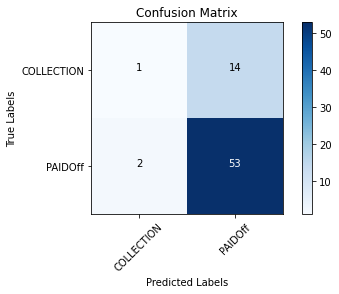

In [106]:
# Compute confusion matrix
cnf_matrix_grid = confusion_matrix(y_test, lr_yhat_grid)
np.set_printoptions(precision=2)

print(classification_report(y_test, lr_yhat_grid))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grid, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using Results from GridSearchCV

In [107]:
# Metric Scores as per the Best Values of Hypermeters Identified by the GridSearchCV
f1_train_lr_grid = f1_score(y_train, lr_model_grid.predict(X_train), average = 'weighted')
f1_test_lr_grid = f1_score(y_test, lr_yhat_grid, average = 'weighted')

jaccard_train_lr_grid = jaccard_score(y_train, lr_model_grid.predict(X_train), average = 'weighted')
jaccard_test_lr_grid = jaccard_score(y_test, lr_yhat_grid, average = 'weighted')

accuracy_train_lr_grid = accuracy_score(y_train, lr_model_grid.predict(X_train))
accuracy_test_lr_grid = accuracy_score(y_test, lr_yhat_grid)

logloss_train_lr_grid = log_loss(y_train, lr_model_grid.predict_proba(X_train))
logloss_test_lr_grid = log_loss(y_test, lr_y_prob_grid)

In [108]:
print("Train Set F1 Score Using Results from GridSearchCV: ", f1_train_lr_grid)
print("Test Set F1 Score Using Results from GridSearchCV: ", f1_test_lr_grid)
print("\n")
print("Score Train Set Jaccard Score Using Results from GridSearchCV: ", jaccard_train_lr_grid)
print("Test Set Jaccard Score Using Results from GridSearchCV: ", jaccard_test_lr_grid)
print("\n")
print("Train Set Accuracy Score Using Results from GridSearchCV: ", accuracy_train_lr_grid)
print("Test Set Accuracy Score Using Results from GridSearchCV: ", accuracy_test_lr_grid)
print("\n")
print("Train Set Log Loss Score Using Results from GridSearchCV: ", logloss_train_lr_grid)
print("Test Set Log Loss Score Using Results from GridSearchCV: ", logloss_test_lr_grid)

Train Set F1 Score Using Results from GridSearchCV:  0.6923668847394484
Test Set F1 Score Using Results from GridSearchCV:  0.7064793130366899


Score Train Set Jaccard Score Using Results from GridSearchCV:  0.5858570618296018
Test Set Jaccard Score Using Results from GridSearchCV:  0.6161247107538668


Train Set Accuracy Score Using Results from GridSearchCV:  0.7536231884057971
Test Set Accuracy Score Using Results from GridSearchCV:  0.7714285714285715


Train Set Log Loss Score Using Results from GridSearchCV:  0.4336415475831813
Test Set Log Loss Score Using Results from GridSearchCV:  0.48275353245267283


## Option 2) Searching for the Best Hyperparameters Using RandomisedSearchCV
- This search is to be used when the number of hyperparameters to be searched are more
- While it’s possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, but it surprisingly picks the best result more often than not and in a fraction of the time it takes for GridSearchCV
- With small data sets and lots of resources, Grid Search will produce accurate results
- However, with large data sets, the high dimensions will greatly slow down computation time in Grid Search and hence, turn out to be very costly
- In such a case (when there are a lot of hyperparameters to be searched), it is advised to use Randomized Search
- Similar to the GridSearchCV, We can use this option to search for the best values of different hyperparameters in the Logistic Regression Algorithm like 'C', 'penalty', 'solver', etc.
- Note: For this option, 'random_state' is to be used so that the results remain constant and does not change every time this Search option is run

In [109]:
lr = LogisticRegression()

params = {
            'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
            'C' : np.arange(0, 1, 0.001),
            'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
        }

random_lr = RandomizedSearchCV(estimator = lr,
                        param_distributions = params,
                        scoring = 'accuracy',
                        cv = 10,
                        verbose = 1,
                        n_jobs = -1,
                        random_state = 5)

# Fitting the Model as per the Hyperparameters Identified by the RandomisedSearchCV
random_lr.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ nan 0.71 0.73 0.74  nan 0.74  nan  nan 0.71 0.71]
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0....
       0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.97, 0.97,
       0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.  , 1.  , 1.  , 1.  ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['liblinear', 'newton-cg',
                             

In [110]:
# Extracting Best Parameters
print(random_lr.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.276}


In [111]:
# Score for the Best Fit
print(random_lr.score(X_test, y_test))

0.7714285714285715


### Training the Model Using Results from RandomisedSearchCV

In [112]:
# Logistic Regression Model with the Best Hyperparameters
lr_model_rcv = LogisticRegression(solver = random_lr.best_params_['solver'], C = random_lr.best_params_['C'], penalty = random_lr.best_params_['penalty'])

# Fitting the Model to the Training Set
lr_model_rcv.fit(X_train, y_train)

lr_model_rcv

LogisticRegression(C=0.276, penalty='l1', solver='liblinear')

### Predicting the y_hat Using Results from RandomisedSearchCV

In [113]:
# Predicting the yhat for the Test Set
lr_yhat_rcv = lr_model_rcv.predict(X_test)
lr_y_prob_rcv = lr_model_rcv.predict_proba(X_test)
lr_yhat_rcv[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [114]:
print(lr_model_rcv.score(X_test, y_test))

0.7714285714285715


### Plotting the Confusion Matrix Using Results from RandomisedSearchCV

              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion Matrix, without Normalization
[[ 1 14]
 [ 2 53]]


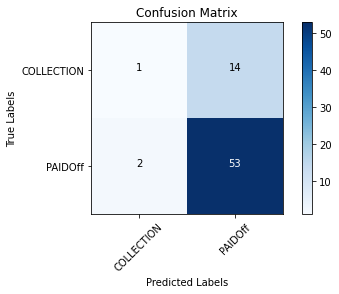

In [115]:
# Compute confusion matrix
cnf_matrix_rcv = confusion_matrix(y_test, lr_yhat_rcv)
np.set_printoptions(precision=2)

print(classification_report(y_test, lr_yhat_rcv))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rcv, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using Results from RandomisedSearchCV

In [116]:
# Metric Scores as per the Best Values of Hypermeters Identified by the RandomisedSearchCV
f1_train_lr_rcv = f1_score(y_train, lr_model_rcv.predict(X_train), average = 'weighted')
f1_test_lr_rcv = f1_score(y_test, lr_yhat_rcv, average = 'weighted')

jaccard_train_lr_rcv = jaccard_score(y_train, lr_model_rcv.predict(X_train), average = 'weighted')
jaccard_test_lr_rcv = jaccard_score(y_test, lr_yhat_rcv, average = 'weighted')

accuracy_train_lr_rcv = accuracy_score(y_train, lr_model_rcv.predict(X_train))
accuracy_test_lr_rcv = accuracy_score(y_test, lr_yhat_rcv)

logloss_train_lr_rcv = log_loss(y_train, lr_model_rcv.predict_proba(X_train))
logloss_test_lr_rcv = log_loss(y_test, lr_y_prob_rcv)

In [117]:
print("Train Set F1 Score Using Results from RandomisedSearchCV: ", f1_train_lr_rcv)
print("Test Set F1 Score Using Results from RandomisedSearchCV: ", f1_test_lr_rcv)
print("\n")
print("Score Train Set Jaccard Score Using Results from RandomisedSearchCV: ", jaccard_train_lr_rcv)
print("Test Set Jaccard Score Using Results from RandomisedSearchCV: ", jaccard_test_lr_rcv)
print("\n")
print("Train Set Accuracy Score Using Results from RandomisedSearchCV: ", accuracy_train_lr_rcv)
print("Test Set Accuracy Score Using Results from RandomisedSearchCV: ", accuracy_test_lr_rcv)
print("\n")
print("Train Set Log Loss Score Using Results from RandomisedSearchCV: ", logloss_train_lr_rcv)
print("Test Set Log Loss Score Using Results from RandomisedSearchCV: ", logloss_test_lr_rcv)

Train Set F1 Score Using Results from RandomisedSearchCV:  0.6923668847394484
Test Set F1 Score Using Results from RandomisedSearchCV:  0.7064793130366899


Score Train Set Jaccard Score Using Results from RandomisedSearchCV:  0.5858570618296018
Test Set Jaccard Score Using Results from RandomisedSearchCV:  0.6161247107538668


Train Set Accuracy Score Using Results from RandomisedSearchCV:  0.7536231884057971
Test Set Accuracy Score Using Results from RandomisedSearchCV:  0.7714285714285715


Train Set Log Loss Score Using Results from RandomisedSearchCV:  0.42896185381476926
Test Set Log Loss Score Using Results from RandomisedSearchCV:  0.4864784597291476


## Option 3) Searching for the Best Value of solver Using 'for' Loop
- When the number of hyperparameters are very less, say, a small range of numbers, then we can also use a simple 'for' loop

In [118]:
solver_for = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
f1_score_lr = []
jaccard_score_lr = []
logloss_score_lr = []

for s in solver_for:
    # Training the Model
    lr_model = LogisticRegression(solver = s)
    # Fitting the Model to the Training Set
    lr_model.fit(X_train, y_train)

    # Predicting the yhat for the Test Set
    lr_yhat = lr_model.predict(X_test)
    lr_y_prob = lr_model.predict_proba(X_test)

    # Finding the Accuracy for Different Solvers
    f1_score_lr.append(f1_score(y_test, lr_yhat, average = 'weighted'))
    jaccard_score_lr.append(jaccard_score(y_test, lr_yhat, average = 'weighted'))
    logloss_score_lr.append(log_loss(y_test, lr_y_prob))

In [119]:
# Best Solver using F1 Score
for s, f in zip(solver_for, f1_score_lr):
    print("Logistic Regression Model with Solver = '{}' has an F1 Score of {} ".format(s, f))

Logistic Regression Model with Solver = 'liblinear' has an F1 Score of 0.685960591133005 
Logistic Regression Model with Solver = 'newton-cg' has an F1 Score of 0.6953867388649997 
Logistic Regression Model with Solver = 'lbfgs' has an F1 Score of 0.6953867388649997 
Logistic Regression Model with Solver = 'sag' has an F1 Score of 0.6953867388649997 
Logistic Regression Model with Solver = 'saga' has an F1 Score of 0.6953867388649997 


In [120]:
# Best Solver using Jaccard Score
for s, j in zip(solver_for, jaccard_score_lr):
    print("Logistic Regression Model with Solver = '{}' has an Jaccard Score of {} ".format(s, j))

Logistic Regression Model with Solver = 'liblinear' has an Jaccard Score of 0.5741023682200154 
Logistic Regression Model with Solver = 'newton-cg' has an Jaccard Score of 0.5865846338535414 
Logistic Regression Model with Solver = 'lbfgs' has an Jaccard Score of 0.5865846338535414 
Logistic Regression Model with Solver = 'sag' has an Jaccard Score of 0.5865846338535414 
Logistic Regression Model with Solver = 'saga' has an Jaccard Score of 0.5865846338535414 


In [121]:
# Best Solver using Log Loss Score
for s, l in zip(solver_for, logloss_score_lr):
    print("Logistic Regression Model with Solver = '{}' has an Log Loss Score of {} ".format(s, l))

Logistic Regression Model with Solver = 'liblinear' has an Log Loss Score of 0.4999471617580585 
Logistic Regression Model with Solver = 'newton-cg' has an Log Loss Score of 0.5001813800859983 
Logistic Regression Model with Solver = 'lbfgs' has an Log Loss Score of 0.5001817646359402 
Logistic Regression Model with Solver = 'sag' has an Log Loss Score of 0.5001513424451315 
Logistic Regression Model with Solver = 'saga' has an Log Loss Score of 0.5001137115457055 


### Creating a df to Check the Best Value of solver Using 'for' Loop

In [122]:
result_lr = pd.DataFrame([f1_score_lr, jaccard_score_lr, logloss_score_lr], index = ['F1 Score', 'Jaccard Score', 'Log Loss Score'], columns = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'])
result_lr.columns.name = 'Solver'
result_lr

Solver,liblinear,newton-cg,lbfgs,sag,saga
F1 Score,0.685961,0.695387,0.695387,0.695387,0.695387
Jaccard Score,0.574102,0.586585,0.586585,0.586585,0.586585
Log Loss Score,0.499947,0.500181,0.500182,0.500151,0.500114


### Plotting the Solver V/s F1 Score Using 'for' Loop

Text(0, 0.5, 'F1 Score')

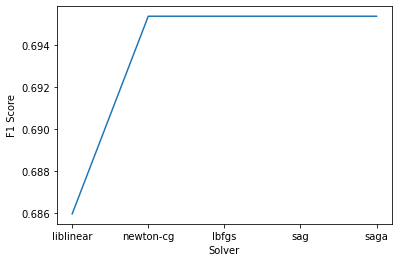

In [123]:
plt.plot(solver_for, f1_score_lr)
plt.xlabel('Solver')
plt.ylabel('F1 Score')

### Plotting the Solver V/s Jaccard Score Using 'for' Loop

Text(0, 0.5, 'Jaccard Score')

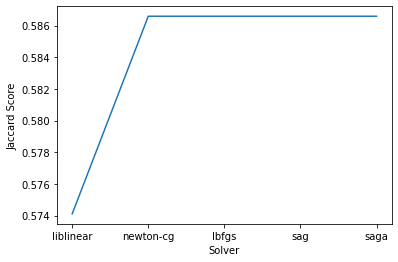

In [124]:
plt.plot(solver_for, jaccard_score_lr)
plt.xlabel('Solver')
plt.ylabel('Jaccard Score')

### Plotting the Solver V/s Log Loss Score Using 'for' Loop

Text(0, 0.5, 'Log Loss Score')

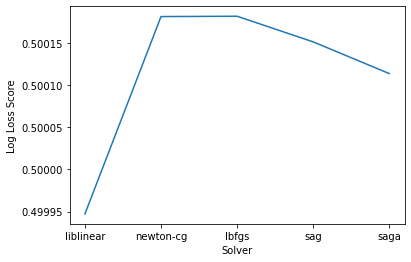

In [125]:
plt.plot(solver_for, logloss_score_lr)
plt.xlabel('Solver')
plt.ylabel('Log Loss Score')

### Best Solver as per the Charts Using 'for' Loop
- The solvers, 'newton-cg', 'lbfgs', 'sag' and 'saga', all have equal F1 Scores as well as Jaccard Scores
- While as per the Log Loss Score, 'liblinear' has the lowest score
- Since, F1 Scores & Jaccard Scores are giving similar results, we will consider them for the Solver selection
- Lets use the first solver, 'newton-cg', as per the F1 & Jaccard Scores for this Logistic Regression

### Training the Model Using 'for' Loop

In [126]:
# Initiating Variables
solver_for = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
               
# Support Vector Machine Model with the Best Kernel Function as per F1 Score
lr_model_for = LogisticRegression(solver = solver_for[(f1_score_lr.index(max(f1_score_lr)))])

# Fitting the Model to the Training Set
lr_model_for.fit(X_train, y_train)

lr_model_for

LogisticRegression(solver='newton-cg')

In [127]:
solver_for[(f1_score_lr.index(max(f1_score_lr)))]

'newton-cg'

### Predictng the y_hat Using 'for' Loop

In [128]:
lr_yhat_for = lr_model_for.predict(X_test)
lr_y_prob_for = lr_model_for.predict_proba(X_test)
lr_yhat_for[0 : 10]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [129]:
print(lr_model_for.score(X_test, y_test))

0.7285714285714285


### Plotting the Confusion Matrix Using 'for' Loop

              precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Confusion Matrix, without Normalization
[[ 2 13]
 [ 6 49]]


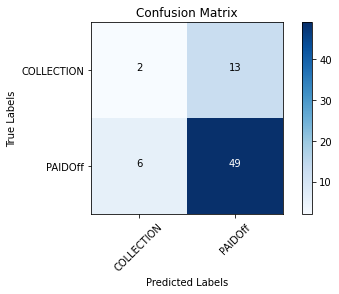

In [130]:
# Compute confusion matrix
cnf_matrix_for = confusion_matrix(y_test, lr_yhat_for)
np.set_printoptions(precision=2)

print(classification_report(y_test, lr_yhat_for))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_for, classes=['COLLECTION','PAIDOff'], normalize= False,  title='Confusion Matrix')

### Accuracy Evaluation Using 'for' Loop

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [131]:
# Metric Scores as per the Best Values of Hypermeters Identified by the 'for' Loop
f1_train_lr_for = f1_score(y_train, lr_model_for.predict(X_train), average = 'weighted')
f1_test_lr_for = f1_score(y_test, lr_yhat_for, average = 'weighted')

jaccard_train_lr_for = jaccard_score(y_train, lr_model_for.predict(X_train), average = 'weighted')
jaccard_test_lr_for = jaccard_score(y_test, lr_yhat_for, average = 'weighted')

accuracy_train_lr_for = accuracy_score(y_train, lr_model_for.predict(X_train))
accuracy_test_lr_for = accuracy_score(y_test, lr_yhat_for)

logloss_train_lr_for = log_loss(y_train, lr_model_for.predict_proba(X_train))
logloss_test_lr_for = log_loss(y_test, lr_y_prob_for)

In [132]:
print("Train Set F1 Score Using Results from 'for' Loop: ", f1_train_lr_for)
print("Test Set F1 Score Using Results from 'for' Loop: ", f1_test_lr_for)
print("\n")
print("Score Train Set Jaccard Score Using Results from 'for' Loop: ", jaccard_train_lr_for)
print("Test Set Jaccard Score Using Results from 'for' Loop: ", jaccard_test_lr_for)
print("\n")
print("Train Set Accuracy Score Using Results from 'for' Loop: ", accuracy_train_lr_for)
print("Test Set Accuracy Score Using Results from 'for' Loop: ", accuracy_test_lr_for)
print("\n")
print("Train Set Log Loss Score Using Results from 'for' Loop: ", logloss_train_lr_for)
print("Test Set Log Loss Score Using Results from 'for' Loop: ", logloss_test_lr_for)

Train Set F1 Score Using Results from 'for' Loop:  0.747887639191987
Test Set F1 Score Using Results from 'for' Loop:  0.6953867388649997


Score Train Set Jaccard Score Using Results from 'for' Loop:  0.6280297351324338
Test Set Jaccard Score Using Results from 'for' Loop:  0.5865846338535414


Train Set Accuracy Score Using Results from 'for' Loop:  0.7717391304347826
Test Set Accuracy Score Using Results from 'for' Loop:  0.7285714285714285


Train Set Log Loss Score Using Results from 'for' Loop:  0.42108037479383287
Test Set Log Loss Score Using Results from 'for' Loop:  0.5001813800859983


## Accuracy Evaluation for Support Vector Machine

### Creating a df to check the Accuracy Evaluation Using the 3 Search Options

In [133]:
lr_scores = {'GridSearchCV - Train' : [f1_train_lr_grid, jaccard_train_lr_grid, accuracy_train_lr_grid, logloss_train_lr_grid],
              'GridSearchCV - Test' : [f1_test_lr_grid, jaccard_test_lr_grid, accuracy_test_lr_grid, logloss_test_lr_grid],
              'RamdomisedSearchCV - Train' : [f1_train_lr_rcv, jaccard_train_lr_rcv, accuracy_train_lr_rcv, logloss_train_lr_rcv],
              'RamdomisedSearchCV - Test' : [f1_test_lr_rcv, jaccard_test_lr_rcv, accuracy_test_lr_rcv, logloss_test_lr_rcv],
              'For Loop - Train' : [f1_train_lr_for, jaccard_train_lr_for, accuracy_train_lr_for, logloss_train_lr_for],
              'For Loop - Test' : [f1_test_lr_for, jaccard_test_lr_for, accuracy_test_lr_for, logloss_test_lr_for]
             }

index = ['F1 Score', 'Jaccard Score', 'Accuracy Score', 'Log Loss Score']

col = ['GridSearchCV - Train', 'GridSearchCV - Test', 'RamdomisedSearchCV - Train', 'RamdomisedSearchCV - Test', 'For Loop - Train', 'For Loop - Test']

lr_hyperparameters_df = pd.DataFrame(lr_scores, index = index, columns = col)

lr_hyperparameters_df.columns.name = 'Logistic Regression Scores'

lr_hyperparameters_df

Logistic Regression Scores,GridSearchCV - Train,GridSearchCV - Test,RamdomisedSearchCV - Train,RamdomisedSearchCV - Test,For Loop - Train,For Loop - Test
F1 Score,0.692367,0.706479,0.692367,0.706479,0.747888,0.695387
Jaccard Score,0.585857,0.616125,0.585857,0.616125,0.628030,0.586585
Accuracy Score,0.753623,0.771429,0.753623,0.771429,0.771739,0.728571
Log Loss Score,0.433642,0.482754,0.428962,0.486478,0.421080,0.500181


## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Model Evaluation using Test Set


In [134]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [135]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-05-14 15:01:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100%  789M=0s

2021-05-14 15:02:00 (789 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test Set for Evaluation


In [136]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Preprocessing the Test Set

### Convert to date time Object

In [137]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [138]:
test_df.shape

(54, 10)

In [139]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

### Insert Additional Columns

In [140]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x : 1 if (x > 3) else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


### Convert Categorical Features to Numerical Values

In [141]:
test_df.groupby(['Gender'])['loan_status'].value_counts()

Gender  loan_status
female  PAIDOFF         8
        COLLECTION      3
male    PAIDOFF        32
        COLLECTION     11
Name: loan_status, dtype: int64

In [142]:
test_df['Gender'].replace(to_replace = ['male', 'female'], value = [0, 1], inplace = True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


### Use One Hot Encoding Technique to Convert Categorical Variables to Binary Variables and Append Them to the Feature Data Frame


In [143]:
test_df['education'].value_counts()

college                 23
High School or Below    21
Bechalor                 8
Master or Above          2
Name: education, dtype: int64

In [144]:
test_df.groupby(['education'])['loan_status'].value_counts()

education             loan_status
Bechalor              PAIDOFF         8
High School or Below  PAIDOFF        11
                      COLLECTION     10
Master or Above       PAIDOFF         2
college               PAIDOFF        19
                      COLLECTION      4
Name: loan_status, dtype: int64

In [145]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis = 1)
test_Feature.drop(['Master or Above'], axis = 1, inplace = True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Normalise Data

In [146]:
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0 : 5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [147]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## K Nearest Neighbor

In [148]:
knn

KNeighborsClassifier(n_neighbors=7)

### Predicting the y_hat for the Test Set

In [149]:
knn_yhat = knn.predict(test_X)
knn_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION'],
      dtype=object)

### Finding the Accuracy Scores

In [150]:
jaccard_score_knn = jaccard_score(test_y, knn_yhat, average = 'weighted')
print("K Nearest Neighbor Jaccard Score for the Test Set: ", jaccard_score_knn)

K Nearest Neighbor Jaccard Score for the Test Set:  0.5102564102564102


In [151]:
f1_score_knn = f1_score(test_y, knn_yhat, average = 'weighted')
print("K Nearest Neighbor F1 Score: ", f1_score_knn)

K Nearest Neighbor F1 Score:  0.6328400281888654


## Decision Tree

In [152]:
dt

DecisionTreeClassifier(max_depth=15)

### Predicting the y_hat for the Test Set

In [153]:
dt_yhat = dt.predict(test_X)
dt_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION'],
      dtype=object)

### Finding the Accuracy Scores

In [154]:
jaccard_score_dt = jaccard_score(test_y, dt_yhat, average = 'weighted')
print("Decision Tree Jaccard Score for the Test Set: ", jaccard_score_dt)

Decision Tree Jaccard Score for the Test Set:  0.5484305227213029


In [155]:
f1_score_dt = f1_score(test_y, dt_yhat, average = 'weighted')
print("Decision Tree F1 Score: ", f1_score_dt)

Decision Tree F1 Score:  0.6942854039628232


## Support Vector Machine

In [156]:
random_svc.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 1, 'C': 0.223}

### Predicting the y_hat for the Test Set

In [157]:
svc_yhat = random_svc.predict(test_X)
svc_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Finding the Accuracy Scores

In [158]:
jaccard_score_svc = jaccard_score(test_y, svc_yhat, average = 'weighted')
print("Support Vector Machine Jaccard Score for the Test Set: ", jaccard_score_svc)

Support Vector Machine Jaccard Score for the Test Set:  0.5486968449931412


In [159]:
f1_score_svc = f1_score(test_y, svc_yhat, average = 'weighted')
print("Support Vector Machine F1 Score: ", f1_score_svc)

Support Vector Machine F1 Score:  0.6304176516942475


## Logistic Regression

In [160]:
random_lr.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.276}

### Predicting the y_hat for the Test Set

In [161]:
lr_yhat = random_lr.predict(test_X)
lr_y_prob = random_lr.predict_proba(test_X)
lr_yhat[0 : 10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Finding the Accuracy Scores

In [162]:
jaccard_score_lr = jaccard_score(test_y, lr_yhat, average = 'weighted')
print("Logistice Regression Jaccard Score for the Test Set: ", jaccard_score_lr)

Logistice Regression Jaccard Score for the Test Set:  0.5775681341719078


In [163]:
f1_score_lr = f1_score(test_y, lr_yhat, average = 'weighted')
print("Logistice Regression F1 Score for the Test Set: ", f1_score_lr)

Logistice Regression F1 Score for the Test Set:  0.6717642373556352


In [164]:
logloss_score_lr = log_loss(test_y, lr_y_prob)
print("Logistice Regression Log Loss Score for the Test Set: ", logloss_score_lr)

Logistice Regression Log Loss Score for the Test Set:  0.4788442232422938


In [165]:
Jaccard_Score = [jaccard_score_knn, jaccard_score_dt, jaccard_score_svc, jaccard_score_lr]

In [166]:
F1_Score = [f1_score_knn, f1_score_dt, f1_score_svc, f1_score_lr]

In [167]:
LogLoss_Score = ['NA', 'NA', 'NA', logloss_score_lr]

In [168]:
accuracy_scores = {
                    'Jaccard' : Jaccard_Score,
                    'F1-score' : F1_Score,
                    'LogLoss' : LogLoss_Score
                    }

In [169]:
index = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
columns = ['Jaccard', 'F1-score', 'LogLoss']

In [170]:
accuracy_df = pd.DataFrame(accuracy_scores, index = index, columns = columns)
accuracy_df.columns.name = 'Algorithm'
accuracy_df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.510256,0.632840,NA
Decision Tree,0.548431,0.694285,NA
SVM,0.548697,0.630418,NA
LogisticRegression,0.577568,0.671764,0.478844


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
